# Libaries

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [22]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [24]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Create dataloaders

In [25]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Explore Data

In [26]:
# Extract class names
for tst, trn in zip(train_data.classes, test_data.classes):
    print(f'{tst:15}{trn:15}')

airplane       airplane       
automobile     automobile     
bird           bird           
cat            cat            
deer           deer           
dog            dog            
frog           frog           
horse          horse          
ship           ship           
truck          truck          


In [27]:
class_names = train_data.classes
type(class_names), class_names

(list,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [28]:
# Explore batch of images
for img, lab in test_loader:
    break

['cat' 'ship' 'ship' 'airplane' 'frog' 'frog' 'automobile' 'frog' 'cat'
 'automobile']


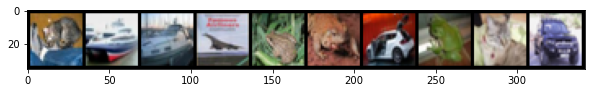

In [29]:
im = make_grid(img, nrow=10)
print(np.array(class_names)[lab])
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)));

# Define a Convolutional Model

[(W−K+2P)/S]+1

- W is the input volume - in your case 128
- K is the Kernel size - in your case 5
- P is the padding - in your case 0 i believe
- S is the stride - which you have not provided.


In [30]:
def output_size(w,k,p,s):
    '''
    Calculates the output size of a convolution/pooling layer.
    - w [int]: input volume
    - k [int]: Kernel size
    - p [int]: padding
    - s [int]: stride
    '''
    return ((w-k+2*p)/s)+1

In [31]:
# Calculate the output number of the layers
c1 = output_size(32,3,0,1)
p1 = output_size(c1,2,0,2)
c2 = output_size(p1,3,0,1)
p2 = output_size(c2,2,0,2)

print(f'Input=32 > C1={c1} > P1={p1} > C2={c2} > P2={p2}')

Input=32 > C1=30.0 > P1=15.0 > C2=13.0 > P2=6.5


In [32]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        # Instantiate nn.Module
        super().__init__()
        
        # First convolution, 3 inputs (RGB), 6 out channels, 5x5 kernel, 1px stride
        self.conv1 = nn.Conv2d(3,6,3,1)
        
        # Second convolution, 6 inputs, 16 out channels, 3x3 kernel, 1px stride
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        # Three fully connected linear layers. Number of inputs as we are reducing the size on
        # each convolution by 1 pixel per side then halving on pooling = (((32-2)/2)-2)//2 = 6
        self.fc1 = nn.Linear(6*6*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, X):
        # Convolution, activation, and max pooling through first two convolution layers
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        # Flatten to [batch number, input after convolutions and pooling]
        X = X.view(-1,6*6*16)
        
        # Pass and activation through two fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        
        # Pass through third fully connected layer
        X = self.fc3(X)
        
        # Final activation to return the probability of belonging to a given class
        return F.log_softmax(X, dim=1)

In [33]:
# Instantiate the model
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
# Checking the number of parameters
n=0
for param in model.parameters():
    n += param.numel()
    print(param.numel())
print(f'--------\n{n}')

162
6
864
16
69120
120
10080
84
840
10
--------
81302


In [35]:
# Define the loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.001)

## Training the model

In [36]:
import time
start_time = time.time()

epochs = 15
# Trackers
train_loss = []
train_correct = []

# Epoch training
for i in range(epochs):
    trn_correct = 0
    tot = 0
    
    for X_train, y_train in train_loader:
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        # Update parameters
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        # Track training accuracy
        tot += X_train.shape[0]
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_correct += batch_corr
        
    print(f'epoch = {i+1:2}\tloss = {loss.item():10.8f}\taccuracy = {trn_correct/tot*100:7.3f}%')
    train_loss.append(loss.data)
    train_correct.append(trn_correct)

print(f'Training time = {(time.time()-start_time)/60:.2f} min')

epoch =  1	loss = 0.81899655	accuracy =  39.352%
epoch =  2	loss = 1.47168493	accuracy =  52.380%
epoch =  3	loss = 1.07908273	accuracy =  56.792%
epoch =  4	loss = 0.93050957	accuracy =  59.860%
epoch =  5	loss = 0.80611122	accuracy =  61.856%
epoch =  6	loss = 1.32903028	accuracy =  63.664%
epoch =  7	loss = 1.97332168	accuracy =  64.966%
epoch =  8	loss = 1.08869147	accuracy =  66.430%
epoch =  9	loss = 1.27221346	accuracy =  67.520%
epoch = 10	loss = 0.69855964	accuracy =  68.286%
epoch = 11	loss = 0.67547357	accuracy =  69.292%
epoch = 12	loss = 0.57640958	accuracy =  70.226%
epoch = 13	loss = 0.60074276	accuracy =  70.850%
epoch = 14	loss = 0.49281758	accuracy =  71.628%
epoch = 15	loss = 0.18640880	accuracy =  72.026%
Training time = 5.38 min


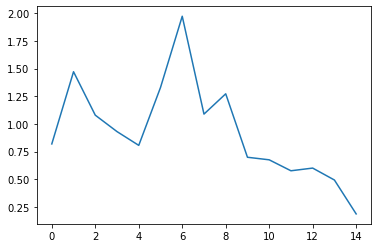

In [37]:
plt.plot(train_loss);

## Test the model

In [38]:
tst_corr = 0
tst_tot = 0

pred_total = []
y_test_total = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        # Apply the model
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        
        # Track accuracy
        tst_tot += X_test.shape[0]
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted==y_test).sum()
        tst_corr += batch_corr
        
        pred_total.append(predicted)
        y_test_total.append(y_test)
        
    print(f'loss = {loss.item():10.8f}\taccuracy = {tst_corr/tst_tot*100:7.3f}%')

loss = 1.30919909	accuracy =  61.210%


In [39]:
y_test_total = torch.concat(y_test_total)
pred_total = torch.concat(pred_total)
cm = confusion_matrix(y_test_total, pred_total)

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Actual')]

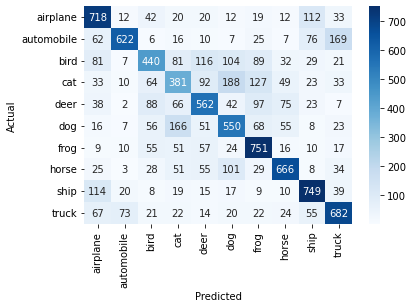

In [40]:
df_cm = pd.DataFrame(cm,class_names, class_names)
cm_plot = sns.heatmap(df_cm,annot=True,cmap='Blues',fmt='g')
cm_plot.set(xlabel='Predicted',ylabel='Actual')

In [56]:
pd.DataFrame(np.diag(cm)/np.sum(cm,axis=1)*100,class_names,['Pct Correct'])\
.sort_values(by='Pct Correct', ascending=False)

,Pct Correct
frog,75.1
ship,74.9
airplane,71.8
truck,68.2
horse,66.6
automobile,62.2
deer,56.2
dog,55.0
bird,44.0
cat,38.1


# Examine Misses

In [57]:
# Get missed items indexes
missed_idx = np.where(pred_total.numpy()!=y_test_total.numpy())[0]
missed_idx.shape

(3879,)

In [58]:
# Setup iterator for verification
row = iter(np.array_split(missed_idx,len(missed_idx)//10))

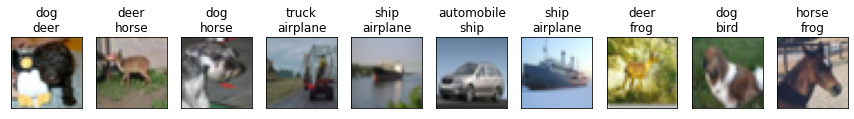

In [84]:
nextrow = next(row)
lab = y_test_total.index_select(0,torch.tensor(nextrow)).numpy()
guess = pred_total.index_select(0,torch.tensor(nextrow)).numpy()

images = test_data.data[nextrow]
fig, axs = plt.subplots(nrows=1, ncols=len(nextrow), figsize=(15,6))
for ax, im, l, g in zip(axs, images, lab, guess):
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{class_names[l]}\n{class_names[g]}')